# Ch11. 텍스트 분류 (Text Classification)

# v02. 스팸 메일 분류하기 (Spam Detection)

- 이번 챕터에서는 캐글에서 제공하는 정상 메일과 스팸 메일이 섞여져 있는 스팸 메일 데이터를 가지고 데이터에 대한 전처리를 진행하고 바닐라 RNN(Vanilla RNN)을 이용한 스팸 메일 분류기를 구현한다.

<br>

## 2.1 스팸 메일 데이터에 대한 이해

- [다운로드 링크](https://www.kaggle.com/uciml/sms-spam-collection-dataset)

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
data = pd.read_csv("spam.csv", encoding="latin1")

In [3]:
# 총 샘플의 수 확인
print('총 샘플의 수 : ', len(data))

총 샘플의 수 :  5572


In [4]:
# 상위 5개 샘플 출력
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


<br>

### 2.1.1 데이터셋 구성 확인

- 이 데이터에는 총 5개의 열이 있다.
- 여기서 `Unnamed`라는 이름의 3개의 열은 텍스트 분류를 할 때 불필요한 열이다.
- `v1`열은 해당 메일이 스팸인지 아닌지를 나타내는 레이블에 해당되는 열이다.
  - `ham`은 정상 메일을 의미
  - `spam`은 스팸 메일을 의미  


- `v2`열은 메일의 본문을 담고있다.

<br>

### 2.1.2 불필요한 열 제거 및 레이블 정수 인코딩

- 레이블과 메일 내용이 담긴 `v1`열과 `v2`열만 필요하므로, `Unnamed: 2`, `Unnamed: 3`, `Unnamed: 4` 열은 삭제한다.
- 또한, `v1`열에 있는 `ham`과 `spam` 레이블을 각각 숫자 `0`과 `1`로 바꾼다.

In [ ]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

data['v1'] = data['v1'].replace(['ham','spam'], [0, 1])

In [6]:
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


- 불필요한 열이 제거되고, v1열의 값이 숫자로 변환된 것을 확인할 수 있다.

<br>

### 2.1.3 데이터셋 열 타입 확인

- 해당 `data`의 정보를 확인해보자.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


- `v1`열은 정수형, `v2`열은 문자열 데이터를 갖고있다.

<br>

### 2.1.4 결측값 확인

- 혹시 Null 값을 가진 샘플이 있는 지 확인해보자.

In [8]:
data.isnull().values.any()

False

- `False`는 별도의 Null 값은 없음을 의미한다.
- 초기 데이터에 `Unnamed: 2`, `Unnamed: 3`, `Unnamed: 4`열에는 NaN이 있었는데 해당 상태에서 수행하는 `isnull().values.any()`는 `True`를 리턴한다.

<br>

### 2.1.5 중복 데이터 확인 및 제거

- Null 값이 없다면 혹시 데이터에 중복이 있지는 않은 지 확인해보자.

In [9]:
data['v2'].nunique()

5169

- 총 5,572개의 샘플이 존재하는 데 `v2`열에서 중복을 제거한 샘플의 개수가 5,169개라는 것은 403개의 중복 샘플이 존재한다는 의미이다.

In [10]:
data['v1'].nunique()

2

- `v1`열은 0 또는 1의 값만을 가지므로 2가 출력되었다.

<br>

- 중복 샘플을 제거해보자.

In [ ]:
# v2 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['v2'], inplace=True)

In [12]:
print('총 샘플의 수 : ', len(data))

총 샘플의 수 :  5169


- 총 샘플의 수가 5,572개에서 5,169개로 줄었다.

<br>

### 2.1.6 레이블 값의 분포 시각화

- 이제 스팸 메일 유무를 의미하는 레이블 값의 분포를 시각화해보자.

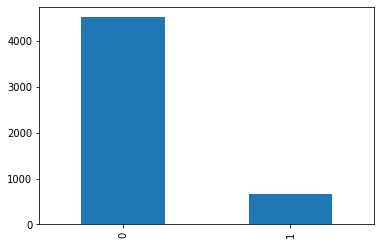

In [13]:
data['v1'].value_counts().plot(kind='bar')
plt.show()

- 레이블이 대부분 0에 편중되어 있다.
- 이는 스팸 메일 데이터의 대부분의 메일이 정상 메일임을 의미한다.

- 수치로 이를 확인해보자.

In [14]:
print(data.groupby('v1').size().reset_index(name='count'))

   v1  count
0   0   4516
1   1    653


- 레이블 0은 총 4,516개가 존재하고 1은 653개가 존재한다.

<br>

### 2.1.7 X와 y 분리

- 이제 X와 y를 분리한다.
- `v2`열을 X, `v1`열을 y로 저장한다.

In [15]:
X_data = data['v2']
y_data = data['v1']

print('메일 본문의 개수 : {}'.format(len(X_data)))
print('레이블의 개수 : {}'.format(len(y_data)))

메일 본문의 개수 : 5169
레이블의 개수 : 5169


- 이제 메일의 본문은 `X_data`에 각 메일의 본문에 대한 `1`과 `0`의 값을 가진 레이블은 `y_data`에 저장하였다.
- 개수는 둘 다 5,169개이다.

<br>

### 2.1.8 토큰화 및 정수 인코딩

- 이제 케라스 토크나이저를 통해 토큰화와 정수 인코딩 과정을 수행해보자.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장

- `sequences`에는 `X_data`의 단어들이 각 단어에 맵핑되는 정수로 인코딩되어 저장되었다.

- 5,169개의 메일이 있으나, 5개의 메일만 출력해서 확인해보겠습니다.

In [17]:
print(sequences[:5])

[[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137], [49, 306, 1364, 435, 6, 1767], [53, 537, 8, 20, 4, 1016, 934, 2, 220, 2713, 1365, 706, 2714, 2715, 267, 2716, 70, 2713, 2, 2717, 2, 359, 537, 604, 1205, 82, 436, 185, 707, 437, 4015], [6, 226, 152, 23, 347, 2718, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 1768, 198, 105, 438]]


- 각 메일에는 단어가 아니라 단어에 대한 인덱스가 부여된 것을 확인할 수 있다.

- 각 정수가 어떤 단어에 부여되었는 지 확인해보자.

In [ ]:
word_to_index = tokenizer.word_index
print(word_to_index)

```
{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'call': 16, 'have': 17, 'on': 18, '2': 19, 'that': 20, 'now': 21, 'are': 22, 'so': 23, 'but': 24, 'not': 25, 'or': 26, 'do': 27, 'can': 28, 'at': 29, "i'm": 30, 'get': 31, 'be': 32, 'will': 33, 'if': 34, 'ur': 35, 'with': 36, 'just': 37, 'no': 38, 'we': 39, 'this': 40, 'gt': 41, '4': 42, 'lt': 43, 'up': 44, 'when': 45, 'ok': 46, 'free': 47, 'from': 48, 'how': 49, 'go': 50, 'all': 51, 'out': 52, - 이하 생략}
```

- `X_data`에 존재하는 모든 단어와 부여된 인덱스를 리턴한다.
- 위에서 부여된 각 정수는 각 단어의 빈도수가 높을 수록 낮은 정수가 부여됐다.
- 다시 말해, 단어 `i`는 현재 전체 훈련 데이터에서 빈도수가 가장 높은 단어이다.

<br>

- 각 단어에 대한 등장 빈도수는 `tokenizer.word_counts().items()`를 출력해서 확인할 수 있다.

In [ ]:
tokenizer.word_counts.items()

```
odict_items([('go', 271), ('until', 27), ('jurong', 1), ('point', 13), ('crazy', 15), ('available', 16), ('only', 199), ('in', 826), ('bugis', 7), 이하 생략])
```

- 이를 응용하여 빈도수가 낮은 단어들이 훈련 데이터에서 얼만큼의 비중을 차지하는 지 확인해볼 수 있다.
- 등장 빈도수가 1회 밖에 되지 않는 단어들이 전체 단어 집합에서 얼만큼의 비율을 차지하며, 전체 훈련 데이터에서 등장 빈도로 얼만큼의 비율을 차지하는 지 확인해보자.

In [22]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈돗수가 threshold보다 작은 단어의 등장 빈도수의 총합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if (value < threshold): # 단어의 등장 빈도수가 threshold보다 작으면
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수 : %s' %(threshold - 1, rare_cnt))
print('단어 집합(vocabulary)에서 희귀 단어의 비율 : ', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : ', (rare_freq / total_freq) * 100)

등장 빈도가 1번 이하인 희귀 단어의 수 : 4908
단어 집합(vocabulary)에서 희귀 단어의 비율 :  55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :  6.082538108811501


- 등장 빈도가 `threshold` 값인 2회 미만. 즉, 1회 밖에 되지 않는 단어들은 단어 집합에서 무려 절반 이상을 차지한다.
- 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 ㅈ